dx = 0.1
dt = 0.004
Simulation for M = 10 and a = 0.04 so N = 25
dt/(dx**2) =  0.3999999999999999
The error for this simulation is given by 0.02000787079408088


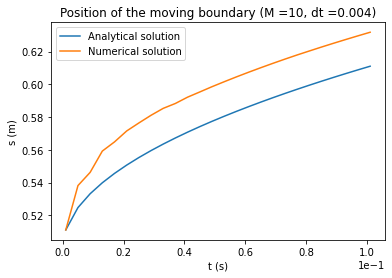

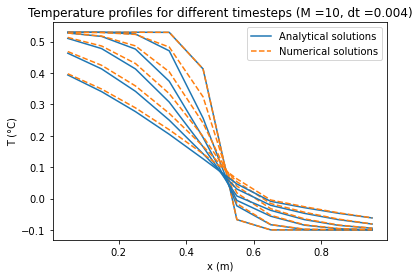

This calculation took 2.38 seconds 

dx = 0.1
dt = 0.002
Simulation for M = 10 and a = 0.02 so N = 50
dt/(dx**2) =  0.19999999999999996
The error for this simulation is given by 0.014503306867226704


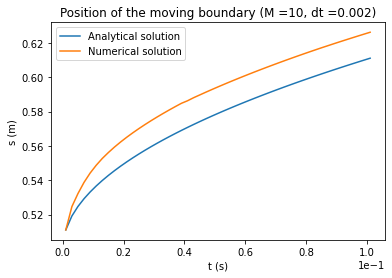

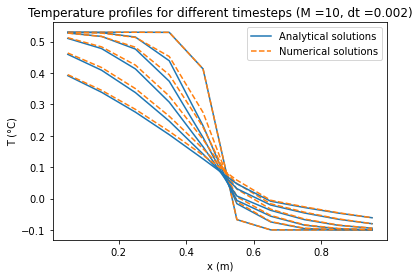

This calculation took 0.31 seconds 

dx = 0.05
dt = 0.002
Simulation for M = 20 and a = 0.04 so N = 50
dt/(dx**2) =  0.7999999999999998
The error for this simulation is given by 0.005652430798266451


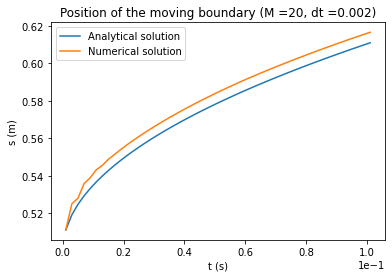

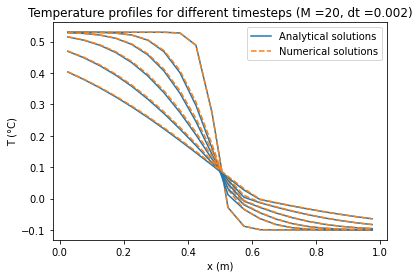

This calculation took 0.32 seconds 

dx = 0.05
dt = 0.001
Simulation for M = 20 and a = 0.02 so N = 99
dt/(dx**2) =  0.3999999999999999
The error for this simulation is given by 0.004335699402264302


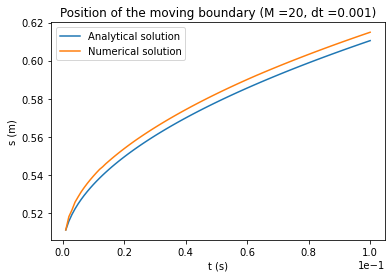

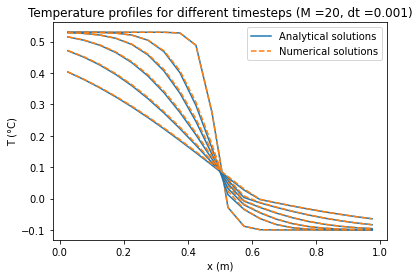

This calculation took 0.38 seconds 

dx = 0.025
dt = 0.001
Simulation for M = 40 and a = 0.04 so N = 99
dt/(dx**2) =  1.5999999999999996
The error for this simulation is given by 0.0013066696183438055


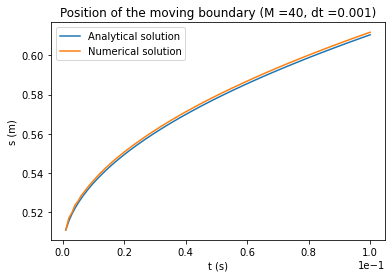

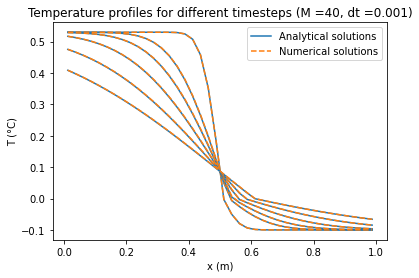

This calculation took 0.4 seconds 

dx = 0.025
dt = 0.0005
Simulation for M = 40 and a = 0.02 so N = 198
dt/(dx**2) =  0.7999999999999998
The error for this simulation is given by 0.0007838538012640352


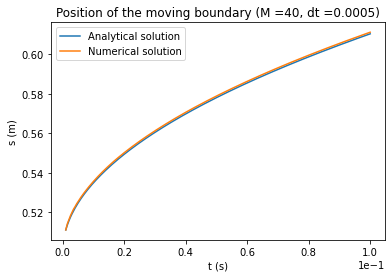

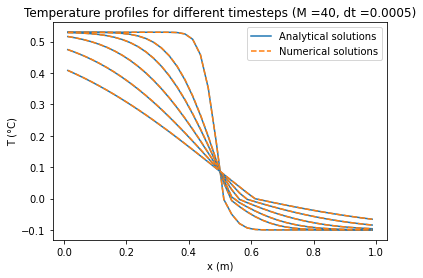

This calculation took 0.55 seconds 

dx = 0.0125
dt = 0.0005
Simulation for M = 80 and a = 0.04 so N = 198
dt/(dx**2) =  3.1999999999999993
The error for this simulation is given by 0.0003456295211140392


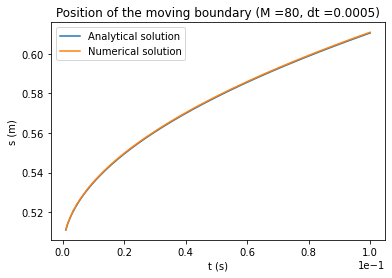

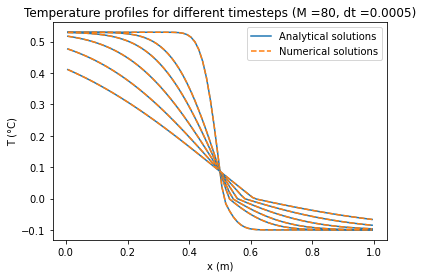

This calculation took 0.58 seconds 

dx = 0.0125
dt = 0.00025
Simulation for M = 80 and a = 0.02 so N = 396
dt/(dx**2) =  1.5999999999999996
The error for this simulation is given by 0.00013196274479457403


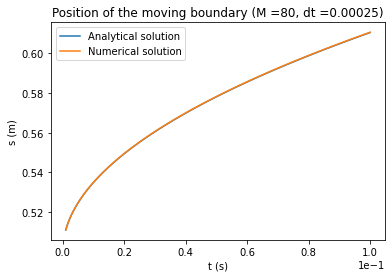

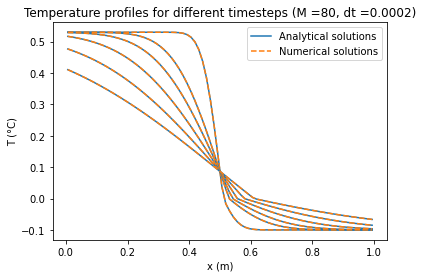

This calculation took 0.78 seconds 

dx = 0.00625
dt = 0.00025
Simulation for M = 160 and a = 0.04 so N = 396
dt/(dx**2) =  6.399999999999999
The error for this simulation is given by 0.0002029843546353066


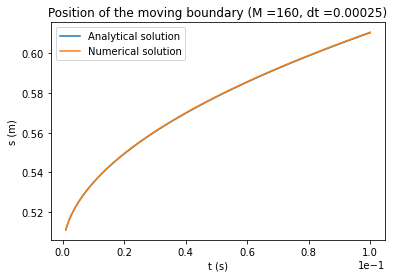

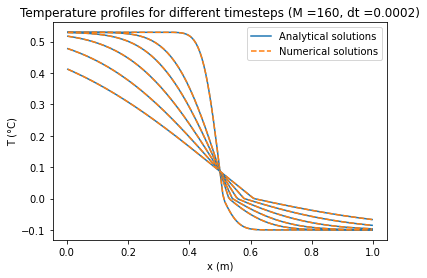

This calculation took 1.31 seconds 

dx = 0.00625
dt = 0.000125
Simulation for M = 160 and a = 0.02 so N = 792
dt/(dx**2) =  3.1999999999999993
The error for this simulation is given by 6.197546455752471e-05


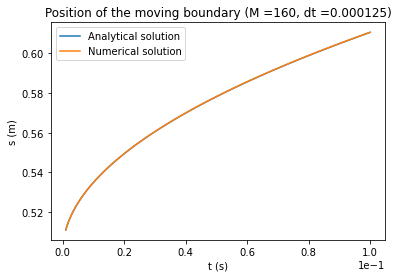

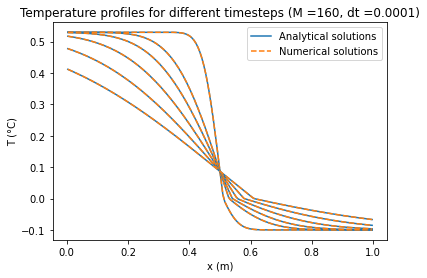

This calculation took 1.87 seconds 

dx = 0.003125
dt = 0.000125
Simulation for M = 320 and a = 0.04 so N = 792
dt/(dx**2) =  12.799999999999997
The error for this simulation is given by 0.00016420534720041637


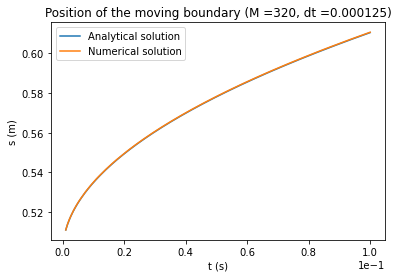

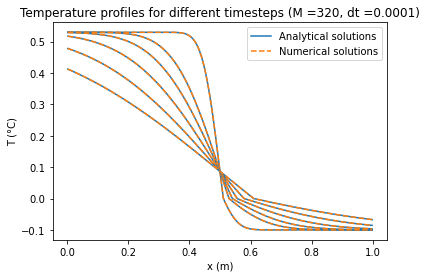

This calculation took 2.51 seconds 

dx = 0.003125
dt = 6.25e-05
Simulation for M = 320 and a = 0.02 so N = 1584
dt/(dx**2) =  6.399999999999999
The error for this simulation is given by 4.084409887242044e-05


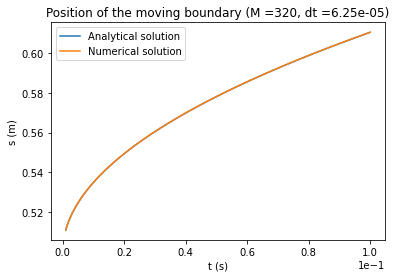

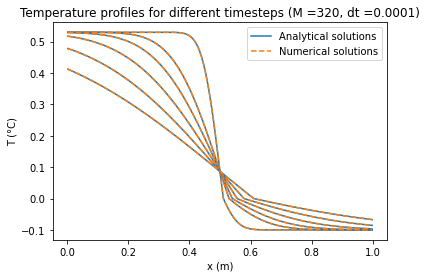

This calculation took 5.59 seconds 

dx = 0.0015625
dt = 6.25e-05
Simulation for M = 640 and a = 0.04 so N = 1584
dt/(dx**2) =  25.599999999999994
The error for this simulation is given by 0.00018044940490049492


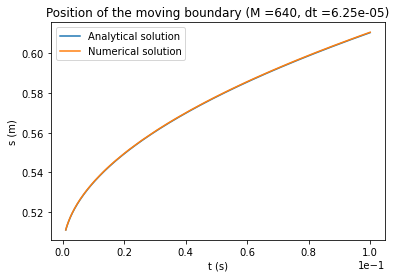

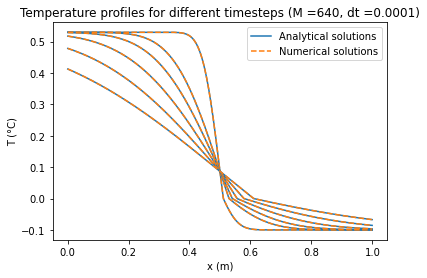

This calculation took 12.51 seconds 

dx = 0.0015625
dt = 3.125e-05
Simulation for M = 640 and a = 0.02 so N = 3168
dt/(dx**2) =  12.799999999999997
The error for this simulation is given by 3.326115649215047e-05


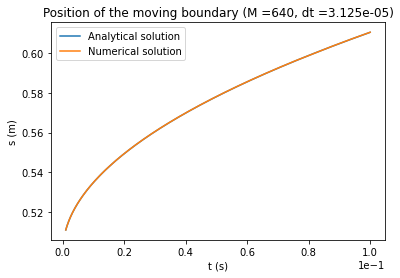

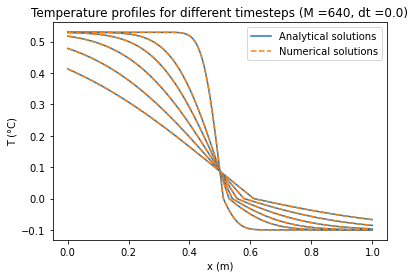

This calculation took 23.69 seconds 



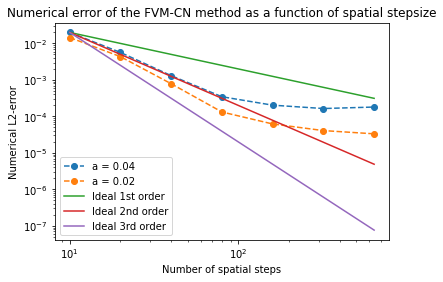

TOTAL SIMULATION TIME: 54.0 seconds


In [25]:
# Last version of the Stefan problem modelled with the level-set method + reinit

### Import necessary modules
import numpy as np
import time as time
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.special import erf, erfc
from scipy.optimize import fsolve, curve_fit
from scipy.interpolate import lagrange
from scipy import linalg as linalg


START_time = time.time() # to compute the computation time

### Plotting parameters
plot_boundary, plot_temperature, plot_errors = True, True, True # set which plots are made

### Set simulation parameters
xmin, xmax = 0.0, 1.0 # domain
tmin, tmax = 0.001, 0.1  # start and end time. Note that tmin>0 in order to start with a smooth profile
M_array = np.array([10,20,40,80, 160, 320, 640], dtype = np.longlong) # numbers of spatial steps
a_array = np.array([1/25, 1/50], dtype = np.double)  # values of a (to compute dt = a*dx)
dx_array = (xmax-xmin)/M_array    # values of dx
errors = np.zeros((len(M_array), len(a_array)), dtype = np.double) # array with errors
 
### Problem parameters
s0 = 0.5 # initial position of the moving boundary
rho = 1.0 # materials density
L = 1.0 # latent heat
ks, kl = 1.0, 1.0 # heat diffusivities of liquid and solid
Tl, Ts, Tm = 0.53, -0.1, 0.0 #initial liquid temperature, solid temperature and melting temperature

### Define functions
def Transcendental(lam):
    """This function is necesessary to find the lambda which is needed to 
    find the analytical solutions to the problem"""
    left = lam
    right = np.sqrt(ks)/(np.sqrt(np.pi)*L)*Ts/erfc(lam/np.sqrt(ks))*np.exp(-lam**2/ks)+np.sqrt(kl)/(np.sqrt(np.pi)*L)*Tl/(2-erfc(lam/np.sqrt(kl)))*np.exp(-lam**2/kl)
    return right-left
def T_analytical(lam,x,t):
    """"This function returns the temperature at a given array of positions
    at a given time.""" 
    s = s0 + 2*lam*np.sqrt(t) # find the position of the moving boundary at time t
    T_ana = np.ones_like(x)*Tm  # create an array with the value of the melting temperature
    T_ana = np.where(x<s,-Tl*erfc(lam/np.sqrt(kl))/(2-erfc(lam/np.sqrt(kl)))+Tl*erfc((x-s0)/(2*np.sqrt(kl*t)))/(2-erfc(lam/np.sqrt(kl))),T_ana) # compute the analytical solution at the left hand side of the boundary
    T_ana = np.where(x>s, Ts - Ts*erfc((x-s0)/(2*np.sqrt(ks*t)))/(erfc(lam/np.sqrt(ks))), T_ana) # compute the analytical solution at the right hand side of the boundary
    return T_ana
def s_analytical(lam, t):
    """This function returns the position of the moving boundary at given time"""
    s = s0 + 2*lam*np.sqrt(t)
    return s
def find_vel(Ti, xi, phi, dx):
    """This function estimates the velocity of the moving boundary by estimating
    the temperature gradients at both sides of the boundary and by using the Stefan condition"""
    Tgradsol = 0 # initial estimate for the gradient at the solid side
    Tgradliq = 0 # inital estimate for the gradient at the liquid side
    j = np.min(np.where(phi<0))-1 # find the index of the grid point in front of the moving boundary
    r1 = -(phi[j]/(phi[j+1]-phi[j])) # find the distance r1 between x_j and the moving interface (s - x_j = r1*dx)
    r2 = (phi[j+1]/(phi[j+1]-phi[j])) # find the distance r1 between x_{j+1} and the moving interface (x_{j+1} - s = r2*dx) 
    xs = xi[j] + r1*dx # find position of the moving boundary
    # Find a second-order Lagrange polynomial and take its derivative to find the gradient jump at the moving boundary.
    pc=1/3
    if r1 <= pc:
        Tgradliq = np.polyder(lagrange([xi[j-2], xi[j-1], xs], [Ti[j-2], Ti[j-1], Tm]))(xs)
    elif r1 > pc:
        Tgradliq = np.polyder(lagrange([ xi[j-1], xi[j], xs], [Ti[j-1], Ti[j], Tm]))(xs)
    if r2 > pc:
        Tgradsol = np.polyder(lagrange([xs, xi[j+1], xi[j+2]], [Tm, Ti[j+1], Ti[j+2]]))(xs)
    elif r2 <=pc:
        Tgradsol = np.polyder(lagrange([xs, xi[j+2], xi[j+3]], [Tm, Ti[j+2], Ti[j+3]]))(xs)  
    return (1/L*(ks*Tgradsol - kl*Tgradliq))
def solve_advection(vels, phi, M, dx, dt):
    """This function solves the advection equation for the given array of 
    constant velocities. It returns the updated advection function."""    
    if len(vels)==1:
        phi_new = phi + dt*vels[-1]
    elif len(vels)==2:
        phi_new = phi + dt/2*(3*vels[-1]-vels[-2])
    else:
        phi_new = phi + dt/2*(vels[-3]-3*vels[-2]+ 4*vels[-1])
    return phi_new 
def update_temp(phi, Ti, t, lam, M, dx, dt):
    """This function updates the temperature profile using the values of the signed
    distance function and the previous temperature at each grid point. This function
    used the FVM-CN scheme for points away from the boundary. Close to the boundary,
    Lagrange interpolation polynomials are used to obtain an estimate for the value close
    to the boundaries using a BE scheme."""
    j = np.min(np.where(phi<0))-1 # find the index of gridpoint in front of the moving boundary
    r1 = -(phi[j]/(phi[j+1]-phi[j])) # find the distance r1 between x_j and the moving interface (s - x_j = r1*dx)
    r2 = (phi[j+1]/(phi[j+1]-phi[j])) # find the distance r1 between x_{j+1} and the moving interface (x_{j+1} - s = r2*dx) 
    A = np.zeros((M,M), dtype = np.double) # set the matrix (FVM-CN, homogeneous Neumann BCs)
    
    T0n = T_analytical(lam, xmin, t) # temperature at left boundary at time t_n
    T0n1 = T_analytical(lam, xmin, t+dt) # temperature at left boundary at time t_{n+1}
    TMn = T_analytical(lam, xmax, t) # temperature at right boundary at time t_n
    Tmn1 = T_analytical(lam, xmax, t+dt) # temperature at right boundary at time t_{n+1}

    for i in range(M):
        if i <j:
            A[i,i] = 2+2*kl*dt/(dx**2)
            A[i,i+1] = -kl*dt/(dx**2)
            if i!=0: A[i,i-1] = -kl*dt/(dx**2)
        elif i==j:
            A[i,i] = 1+kl*dt/(dx**2) * 2/r1
            A[i,i-1] = -kl*dt/(dx**2) * 2/(1+r1)
        elif i==j+1:
            A[i,i] = 1+ks*dt/(dx**2)* 2/r2
            A[i,i+1] = -ks*dt/(dx**2) * 2/(1+r2)
        elif i>j+1:
            A[i,i] = 2+2*ks*dt/(dx**2)
            A[i,i-1] = -ks*dt/(dx**2)
            if i!=M-1: A[i,i+1] = -ks*dt/(dx**2)
    A[0,0] = 2+3*kl*dt/(dx**2)
    A[M-1,M-1] = 2+3*ks*dt/(dx**2)
    Rn = np.zeros(M, dtype = np.double)
    a1 = kl*dt/(dx**2)
    a2 = ks*dt/(dx**2)
    for i in range(1,j):
        Rn[i] = a1*Ti[i-1] + (2-2*a1)*Ti[i] + a1*Ti[i+1]
    for i in range(j+1,M-1):
        Rn[i] = a2*Ti[i-1] + (2-2*a2)*Ti[i] + a2*Ti[i+1]
    Rn[0] = (2-3*a1)*Ti[0] + a1*Ti[1] +2*a1*T0n +2*a1*T0n1
    Rn[M-1] = a2*Ti[M-2] + (2-3*a2)*Ti[M-1] + 2*a2*TMn + 2*a2*Tmn1 
    Rn[j] = Ti[j]
    Rn[j+1] = Ti[j+1]
    Ti = np.linalg.solve(A,Rn) # Solve the matrix equation to find the new value of T
    return Ti
def pos_s(phi, xi):
    """This function returns the position of the moving interface, using the 
    values of the signed distance function"""
    j = np.min(np.where(phi<0))-1 # find the index of the grid point in front of the moving boundary
    r1 = -(phi[j]/(phi[j+1]-phi[j]))
    xs = xi[j] + r1*dx # find position of the moving boundary
    return xs

### Run the program for the given numbers of time- and spatial steps
lam = fsolve(Transcendental, 1.0)[0] # compute the lambda necessary to find the analytical solution

for Mcount, M in enumerate(M_array): # go through al spatial numbers of steps
    for acount, a in enumerate(a_array): # go through al a's
        start_time = time.time()
        dx = dx_array[Mcount] # find dx
        dt = a*dx**1 # find dt
        print("dx =", dx) 
        print("dt =", dt)
        N = round((tmax-tmin)/dt) # compute the number of time steps for which to perform the calculation algorithm
        print("Simulation for M =", M, "and a =", a, "so N =" , N)
        print("dt/(dx**2) = ", dt/(dx**2))
        xi = np.linspace(xmin+1/2*dx,xmax-1/2*dx, M, dtype = np.double) # set a grid with xi at the center of each grid cell Ki
    
        # Initalize t, phi, Ti
        s = s_analytical(lam, tmin) # find the initial boundary position
        t = tmin # set initial time
        phi = s - xi # set initial signed distance function
        Ti = T_analytical(lam, xi, tmin) # set initial temperature distribution
        
        # Create arrays in which the solution is stored
        tarray = np.array([tmin], dtype = np.double) # array with times
        snum = np.array([s], dtype = np.double) # array with numerical boundary position
        sana = np.array([s], dtype = np.double) # array with analytical boundary positions
        Tnum = np.zeros((N+1, M), dtype = np.double) # set array with numerical temperature
        Tnum[0] = Ti
        Tana = np.zeros((N+1, M), dtype = np.double) # set array with analytical temperature
        Tana[0] = Ti
        vels = np.array([], dtype = np.double)
        
        for timestep in range(N):
            v = find_vel(Ti, xi, phi, dx)                  ### Step 1: find the front velocity
            vels = np.append(vels, v)                      ### Store velocity in an array
            phi = solve_advection(vels, phi, M, dx, dt)    ### Step 2: solve the advection equation
            Ti = update_temp(phi, Ti, t, lam, M, dx, dt)   ### Step 3: solve the heat equation
            t = t+dt                                       ### Step 4: update counter
            
            # Check if CFL-condition on advection equation is satisfied
            CFL = v*dt/dx
            max_CFL = 0
            if CFL>max_CFL: max_CFL=CFL
            if CFL>1/2: print("CFL is too big. It is given by:", CFL, "at t =", t)
            
            ### Solve solutions
            xs = pos_s(phi, xi)
            snum = np.append(snum, xs)
            sana = np.append(sana, s_analytical(lam, t))
            tarray = np.append(tarray, t)
            Tnum[timestep+1] = Ti
            Tana[timestep+1] = T_analytical(lam, xi, t)
        
        # Compute the errors
        error_L2 = np.sqrt(1/len(snum))* linalg.norm(snum-sana, ord=2)
        errors[Mcount, acount] = error_L2
        print("The error for this simulation is given by", error_L2)
        
        # Plot the solution for the moving boundary
        if plot_boundary is True:
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.plot(tarray, sana, label="Analytical solution")
            plt.plot(tarray, snum, label="Numerical solution")
            plt.xlabel("t (s)")
            plt.ylabel("s (m)")
            plt.legend()
            plt.title("Position of the moving boundary (M =" + str(M) + ", dt =" + str(dt) + ")")
            plt.show() 
        # plot the temperature    
        if plot_temperature is True:
            for timestep in np.array([0, N/16, N/8, N/4, N/2, N-1]).astype(int):
                plt.plot(xi, Tana[timestep], "C0", label="Analytical solution")
                plt.plot(xi, Tnum[timestep], "C1--", label="Numerical solution")
            plt.xlabel("x (m)")
            plt.ylabel("T (°C)")
            plt.legend(["Analytical solutions", "Numerical solutions"])
            plt.title("Temperature profiles for different timesteps (M =" + str(M) + ", dt =" + str(round(dt,4)) + ")")
            plt.show()
        print("This calculation took", round(time.time()-start_time, 2), "seconds \n")



### Plot the numerical error as a function of the spatial stepsize
if len(M_array)>2:
    for acount, a in enumerate(a_array):
        plt.loglog(M_array, errors[:,acount], "o--", label= "a = " + str(a_array[acount]))
    a1 = np.transpose(errors)[0][0]/(1/M_array[0])
    a2 = np.transpose(errors)[0][0]/(1/M_array[0]**2)
    a3 = np.transpose(errors)[0][0]/(1/M_array[0]**3)
    plt.loglog(M_array, a1/M_array, "-", label="Ideal 1st order")
    plt.loglog(M_array, a2/M_array**2,"-", label="Ideal 2nd order")
    plt.loglog(M_array, a3/M_array**3, "-", label="Ideal 3rd order")
    plt.xlabel(r"Number of spatial steps")
    plt.ylabel("Numerical L2-error")
    plt.legend(prop={'size': 10}, loc="best")
    plt.title("Numerical error of the FVM-CN method as a function of spatial stepsize")
    plt.show()          
        
print("TOTAL SIMULATION TIME:", round(time.time()- START_time, 1), "seconds")       